In [1]:
import torch
import numpy
import pandas as pd
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix
from utils import pytorchtools
import torchvision.transforms.functional as TF
from utils import pytorchtools
import torch.utils.data as data_utils

In [2]:
torch.cuda.empty_cache()

In [3]:
print(torch.__version__)

1.7.0


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 40
patience = 10
batch_size = 1
learning_rate = 0.001
feature_extract = True

### MNIST dataset 

In [89]:
modification=transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.expand(3, -1, -1))
    ])

In [90]:
train_dataset = torchvision.datasets.MNIST(root='..//set', 
                                           train=True, 
                                           transform=modification,  
                                           download=True)

In [91]:
test_dataset = torchvision.datasets.MNIST(root='..///set', 
                                          train=False, 
                                          transform=modification)

In [92]:
# indices = torch.arange(10000)
# tr_10k = data_utils.Subset(train_dataset, indices)
# indices = torch.arange(50000)
# tr_50k = data_utils.Subset(train_dataset, indices)


train_ds  = torch.utils.data.Subset(train_dataset, range(0, 50000-1))
valid_ds = torch.utils.data.Subset(train_dataset, range(50000, 60000-1))





In [93]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_ds, 
                                           batch_size=batch_size, 
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_ds, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


### Model

In [94]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=True).to(device)

Using cache found in C:\Users\Szymon/.cache\torch\hub\pytorch_vision_v0.9.0


### Loss and optimizer

In [95]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
running_loss = 0
losses = []

### Architecture

In [96]:
summary(model, (3,224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

### Train Model

In [97]:
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = []

In [ ]:
for i,param in enumerate(model.parameters()):
    param.requires_grad = False

In [ ]:
for i,p in enumerate(model.classifier.parameters()):
    p.requires_grad = True

In [100]:
summary(model, (3,224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [101]:
size = len(train_loader.dataset)
print(size)

# initialize the early_stopping object
early_stopping = pytorchtools.EarlyStopping(patience=patience, verbose=True)

for epoch in range(num_epochs):
    ##########################    
    #######TRAIN MODEL########
    ##########################
    epochs_loss=0
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        
        #calculate train_loss
        train_losses.append(loss.item())
        optimizer.step()
    
    ##########################    
    #####VALIDATE MODEL#######
    ##########################
    model.eval()
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images).to(device)
        loss = criterion(outputs,labels)
        valid_losses.append(loss.item())
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = numpy.average(train_losses)
    valid_loss = numpy.average(valid_losses)
#     print(train_loss)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    print_msg = (f'train_loss: {train_loss:.5f} ' + f'valid_loss: {valid_loss:.5f}')
    
    print(print_msg)

    
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    
    early_stopping(valid_loss, model)
    print(epoch)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break

49999
train_loss: 0.22164 valid_loss: 0.06151
Validation loss decreased (inf --> 0.061512).  Saving model ...
0
train_loss: 0.04245 valid_loss: 0.05059
Validation loss decreased (0.061512 --> 0.050588).  Saving model ...
1
train_loss: 0.03675 valid_loss: 0.05222
EarlyStopping counter: 1 out of 10
2
train_loss: 0.04845 valid_loss: 0.05104
EarlyStopping counter: 2 out of 10
3
train_loss: 0.05137 valid_loss: 0.12624
EarlyStopping counter: 3 out of 10
4
train_loss: 0.02771 valid_loss: 0.06986
EarlyStopping counter: 4 out of 10
5
train_loss: 0.02334 valid_loss: 0.05083
EarlyStopping counter: 5 out of 10
6
train_loss: 0.01475 valid_loss: 0.05057
Validation loss decreased (0.050588 --> 0.050573).  Saving model ...
7
train_loss: 0.01108 valid_loss: 0.06040
EarlyStopping counter: 1 out of 10
8
train_loss: 0.01956 valid_loss: 0.09382
EarlyStopping counter: 2 out of 10
9
train_loss: 0.01451 valid_loss: 0.15341
EarlyStopping counter: 3 out of 10
10
train_loss: 0.01479 valid_loss: 0.07138
EarlyStop

In [102]:
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

### Loss function vs Epoch

7


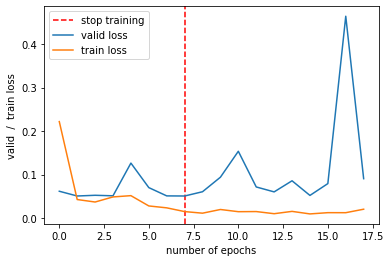

In [103]:
fig = plt.figure()

######1st plot#########
ax1 = fig.add_subplot()
ax1.set_ylabel('valid  /  train loss')
ax1.set_xlabel('number of epochs')
halt = avg_valid_losses.index(min(avg_valid_losses))


plt.axvline(x=halt, color='r', linestyle="--", label="stop training")

print(avg_valid_losses.index(min(avg_valid_losses)))


plt.plot(list(range(len(avg_valid_losses))), avg_valid_losses, label = "valid loss")
plt.plot(list(range(len(avg_valid_losses))), avg_train_losses, label="train loss")

h,labels = ax1.get_legend_handles_labels()
labels[:1] = ['stop training','valid loss', 'train loss',]
ax1.legend(labels=labels)

plt.show()

### Test the model

In [117]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), '.\\models\\alexanet.ckpt')

Accuracy of the network on the 10000 test images: 99.0 %


### Confusion Matrix

In [118]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images).to(device)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [119]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    train_preds = get_all_preds(model, prediction_loader).to(device)
    
train_preds.shape
train_preds.grad_fn
train_preds.grad

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

preds_correct = get_num_correct(train_preds, test_dataset.targets.to(device) )
print('total correct', preds_correct)
print('accuracy', preds_correct / len(test_dataset))
train_preds.is_cuda

total correct 9900
accuracy 0.99


True

In [120]:
stacked = torch.stack((test_dataset.targets.to(device), train_preds.argmax(dim=1)), dim=1)

In [121]:
stacked[9].tolist()

[9, 9]

In [122]:
cmt = torch.zeros(10,10, dtype=torch.int64)

In [138]:
for p in stacked:
    j,k = p.tolist()
    cmt[j,k] = cmt[j, k] + 1

In [139]:
cmt

tensor([[1948,    0,    2,    2,    0,    0,    8,    0,    0,    0],
        [   0, 2266,    2,    0,    0,    0,    0,    2,    0,    0],
        [   2,    2, 2050,    4,    0,    0,    0,    6,    0,    0],
        [   0,    0,    2, 2014,    0,    0,    0,    2,    2,    0],
        [   0,    2,    0,    0, 1926,    0,    8,    2,    8,   18],
        [   0,    0,    2,   24,    0, 1750,    6,    0,    0,    2],
        [   2,    4,    2,    0,    2,    2, 1904,    0,    0,    0],
        [   0,    8,   14,    4,    0,    0,    0, 2026,    0,    4],
        [   2,    0,    2,   10,    0,    0,    6,    0, 1926,    2],
        [   4,    0,    0,    8,   10,    0,    0,    4,    2, 1990]])

In [140]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [141]:
lb = test_dataset.targets.detach().cpu().numpy()

In [142]:
rp = train_preds.argmax(dim=1).detach().cpu().numpy()
print(rp)

[7 2 1 ... 4 5 6]


In [143]:
cm = confusion_matrix(lb, rp)

Confusion matrix, without normalization
[[ 974    0    1    1    0    0    4    0    0    0]
 [   0 1133    1    0    0    0    0    1    0    0]
 [   1    1 1025    2    0    0    0    3    0    0]
 [   0    0    1 1007    0    0    0    1    1    0]
 [   0    1    0    0  963    0    4    1    4    9]
 [   0    0    1   12    0  875    3    0    0    1]
 [   1    2    1    0    1    1  952    0    0    0]
 [   0    4    7    2    0    0    0 1013    0    2]
 [   1    0    1    5    0    0    3    0  963    1]
 [   2    0    0    4    5    0    0    2    1  995]]


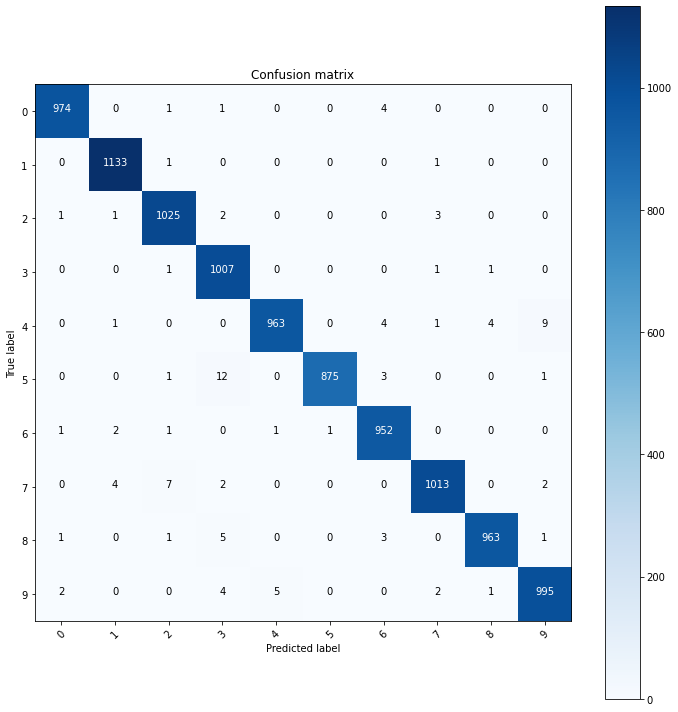

In [147]:
names = set(lb)
plt.figure(figsize=(10,10))
plot_confusion_matrix.plot_confusion_matrix(cm, names)

### Image

In [145]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            target = target.to(device)
            data = data.to(device)
            output = model(data)
            
            test_loss += nn.functional.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Store wrongly predicted images
            wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
            wrong_samples = data[wrong_idx]
            wrong_preds = pred[wrong_idx]
            actual_preds = target.view_as(pred)[wrong_idx]

            for i in range(len(wrong_idx)):
                sample = wrong_samples[i]
                wrong_pred = wrong_preds[i]
                actual_pred = actual_preds[i]
                # Undo normalization
#                 print(wrong_samples[i].shape)
                sample = sample.to(device)
                sample = sample * 0.3081
                sample = sample + 0.1307
                sample = sample * 255.
                sample = sample.byte()
                img = TF.to_pil_image(sample)
                path = '.\\mistakes\\alexanet\\'
                img.save(path+'wrong_idx{}_pred{}_actual{}.png'.format(
                    wrong_idx[i], wrong_pred.item(), actual_pred.item()))

In [146]:
test(model,device, test_loader)